In [1]:
from abc import ABC, abstractmethod
from typing import Callable, Dict, List
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scipy as sp
from scipy.special import binom, factorial
from scipy.integrate import quad
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Increase font size.
font = {'size': 16}
matplotlib.rc('font', **font)

In [2]:
class FourierFunction(ABC):
    """The abstract base class for functions that have analytic Fourier expansions.
    """
    def __init__(self, terms: int, real: bool = True):
        """Construct a function with the specified number of terms.
        
        Args:
            terms (int): The number of terms of the Fourier expansion to approximate with.
            real (bool): Whether the function is purely real; otherwise, has imaginary parts. Defaults to True.
        """
        # Set number of terms.
        # Set whether function is purely real or not.
        self.terms = terms
        self.real = real
        
        # Compute coefficients and modes.
        # Coefficients are indexed: (0 -> -T), (2T + 1 -> T)
        self.coeffs = np.empty(2 * self.terms + 1, dtype=complex)
        for index, mode in enumerate(range(-self.terms, self.terms+1)):
            self.coeffs[index] = self.coeff(mode)
        self.modes = np.arange(-self.terms, self.terms+1)
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Compute the function at a specified array of points.
        
        Args:
            x (numpy.ndarray): The point at which the function should be evaluated at.
            
        Returns:
            numpy.ndarray: The values of the function.
        """
        # Consider vector-valued and single-valued.
        if isinstance(x, np.ndarray):
            # Compute the value.
            # f(x) = sum(c[m] e^(imx))
            value = np.sum(self.coeffs[np.newaxis, :] * np.exp(
                complex(0, 1) * self.modes[np.newaxis, :] * x[:, np.newaxis]
            ), axis=1)
        else:
            value = np.sum(self.coeffs * np.exp(
                complex(0, 1) * self.modes * x))
        
        # Return only the real part if the function is real-only.
        if self.real:
            return np.real(value)
        return value
    
    @abstractmethod
    def coeff(self, mode: int) -> complex:
        """Compute the Fourier coefficient corresponding to a specified Fourier mode.
        
        Args:
            mode (int): The Fourier mode.
            
        Returns
            complex: The Fourier coefficient.
        """
        pass

class SineFunction(FourierFunction):
    """The Fourier expansion of the sine function with particular frequency.
    """
    def __init__(self, terms: int, frequency: int = 1):
        """Construct a sine function with the specified number of terms and frequency.
        
        Args:
            terms (int): The number of terms of the Fourier expansion to approximate with.
            frequency (int, optional): The normalized frequency of the sine wave. This is also the number of complete waves on [-pi, pi]. Defaults to 1.
        """
        # Set frequency.
        self.frequency = frequency
        
        # Create coefficients after setting frequency.
        super().__init__(terms)
    
    def coeff(self, mode: int) -> complex:
        """Compute the Fourier coefficient corresponding to a specified Fourier mode.
        
        Args:
            mode (int): The Fourier mode.
            
        Returns
            complex: The Fourier coefficient.
        """
        if mode not in (-self.frequency, self.frequency):
            return complex(0, 0)
        return complex(0.0, -0.5 * np.sign(mode))

class ReLUFunction(FourierFunction):
    """The Fourier expansion of the Rectified Linear Unit (ReLU) function.
    """
    def __init__(self, terms: int):
        """Construct a ReLU function with the specified number of terms.
        
        Args:
            terms (int): The number of terms of the Fourier expansion to approximate with.
        """
        # Create coefficients.
        super().__init__(terms)
    
    def coeff(self, mode: int) -> complex:
        """Compute the Fourier coefficient corresponding to a specified Fourier mode.
        
        Args:
            mode (int): The Fourier mode.
            
        Returns
            complex: The Fourier coefficient.
        """
        if mode == 0:
            return complex(np.pi / 4, 0)
        else:
            return ((-1) ** mode) / (2 * np.pi * mode ** 2) * complex(1 + (-1) ** (mode + 1), np.pi * mode)
        
class LinearFunction(FourierFunction):
    """The Fourier expansion of the linear function.
    """
    def __init__(self, terms: int, slope: float = 1.0, offset: float = 0.0):
        """Construct a linear function with the specified number of terms, slope, and offset.
        
        Args:
            terms (int): The number of terms of the Fourier expansion to approximate with.
            slope (float, optional): The slope of the linear function. Defaults to 1.0.
            offset (float, optional): The offset of the linear function. Defaults to 0.0.
        """
        self.slope = slope
        self.offset = offset
        
        super().__init__(terms)
        
    def coeff(self, mode: int) -> complex:
        """Compute the Fourier coefficient corresponding to a specified Fourier mode.
        
        Args:
            mode (int): The Fourier mode.
            
        Returns
            complex: The Fourier coefficient.
        """
        if mode == 0:
            return complex(self.offset, 0)
        else:
            return complex(0, 1) * ((-1) ** mode) * self.slope / mode
        
class QuadratureFunction(FourierFunction):
    """The Fourier expansion of a function that must be numerically integrated.
    """
    def __init__(self, terms: int, func: Callable, real: bool = True):
        """Construct a function with the specified number of terms.
        
        Args:
            terms (int): The number of terms of the Fourier expansion to approximate with.
            func (callable): The function to take the Fourier expansion of.
            real (bool, optional): Whether the function is purely real; otherwise, has imaginary parts. Defaults to True.
        """
        # Set the function.
        self.func = func
        
        # Create coefficients after setting function.
        super().__init__(terms, real)
        
    def coeff(self, mode: int) -> complex:
        """Compute the Fourier coefficient corresponding to a specified Fourier mode.
        
        Args:
            mode (int): The Fourier mode.
            
        Returns
            complex: The Fourier coefficient.
        """
        # Integrate imaginary and real parts of Fourier transform.
        imag, _ = quad(self.func, -np.pi, np.pi, weight='sin', wvar=-mode, limit=256)
        real, _ = quad(self.func, -np.pi, np.pi, weight='cos', wvar=-mode, limit=256)
        
        # Return coefficient.
        return complex(real, imag) / (2 * np.pi)

    
class CoefficientsFunction(FourierFunction):
    def __init__(self, coeffs: Dict[int, complex], real: bool = True):
        self.terms = len(coeffs)
        self.real = real
        self.modes = np.array([mode for mode in coeffs])
        self.coeffs = np.array([coeffs[mode] for mode in coeffs])
        
    def coeff(self, mode: int) -> complex:
        return self.coeffs[self.modes.index(mode)]

The algebraic iteration method solves for Fourier coefficients by the following equation.
\begin{equation}
    g_i = \sum_{n\in\mathbb{Z}}^{\infty} s_n \sum_{q=0}^{\infty} \frac{(2\pi in)^q}{q!} \left(\sum_{\substack{q = \sum_{m \in \mathbb{Z}} q_m \\ i=\sum_{m \in \mathbb{Z}} m q_m}} \binom{q}{\ldots, q_{-1}, q_{0}, q_{1}, \dots} \prod_{m \in \mathbb{Z}}f_t^{q_m} \right).
\end{equation}

In [3]:
def multinomial(values: List[int]) -> int:
    """Compute the multinomial coefficient of a list of subpopulations.
    
    Args:
        values (list[int]): The number of members in each subpopulation. Each entry must be non-negative.
    
    Returns
        int: The multinomial coefficient.
    """
    
    # Using recursive method.
    if len(values) == 1:
        return 1
    return binom(sum(values), values[-1]) * multinomial(values[:-1])

In [4]:
def q_indices_naive(q, k, terms):
    # We don't actually need these.
    # These constraints are computed recursively.
    
#     # Order O(T)
#     def index_constraint(qs):
#         return np.sum(qs) == q

#     # Order O(T)
#     def power_constraint(qs):
#         return np.sum(qs * np.arange(-terms, terms + 1)) == k
    
    # We can solve this problem recursively.
    # We loop over the combinations of the outer terms.
    # Then we calculate what the new q and k values need to be.
    # We decrement the number of terms and run the algorithm again.
    
    # Order O(Q >> T)
    if terms == 0:
        for q_val in range(q + 1):
            if k == 0 and q_val == q:
                yield q_val
    # Order O(Q^2) * O(Q^2) * ... O(Q^1) = O(Q^T)
    else:
        qs = np.zeros(terms * 2 + 1)
        for q_left in range(q + 1):
            for q_right in range(q + 1):
                qs[0] = q_left
                qs[-1] = q_right

                new_q = q - (q_left + q_right)
                new_k = k - terms * (q_right - q_left)

                for q_middle in q_indices_naive(new_q, new_k, terms - 1):
                    qs[1:-1] = q_middle
#                     yield np.copy(qs)
                    yield qs
    
def q_indices_fast(q, k, terms):
    pass

In [5]:
class Approximation():
    def __init__(self, approx: Callable, exact: Callable):
        self.approx = approx
        self.exact = exact
        
    def get_approx(self, x):
        # Return approximate function evaluation.
        return self.approx(x)
        
    def get_exact(self, x):
        # Return exact function evaluation.
        return self.exact(x)
    
    def get_error_l2(self, x):
        # Compute midpoint weights in case of unevenly distributed grid points.
        # If grid points are evenly distributed, weights are all equal to step size.
        weights = np.zeros_like(x, dtype=float)
        weights[:-1] += x[1:] - x[:-1]
        weights[1:] += x[1:] - x[:-1]
        weights[1:-1]  = weights[1:-1] / 2
        
        # Return l2 error at every point.
        return weights * (np.abs(self.get_approx(x) - self.get_exact(x)) ** 2)
    
    def apply_integration(self, terms: int, series: FourierFunction):
        # Create the next iteration function.
        integrand = lambda x: self.approx(series(x))
        
        # Compute the appliication.
        return QuadratureFunction(terms, integrand)
    
    def apply_algebraic(self, terms: int, series: FourierFunction):     
        # Define the q-solver method we use.
        q_indices = q_indices_naive
        
        # The number of terms (values of q) in the expansion of e^x.
        sum_terms = 6
        
        # Compute each coefficient within the specified number of terms.
        # Note, we can compute the inner sum independent of n so we can save
        # each one in terms of q and reapply side by side with the second outer sum.
        coeffs = {}
        
        for apply_idx, apply_mode in enumerate(range(-terms, terms + 1)):
            inner_sums = np.zeros(sum_terms, dtype=complex)
            for q in range(sum_terms):
                # Inner (constrained sum).
                coeff_inner = complex(0, 0)
                for q_index in q_indices(q, apply_mode, len(series.coeffs) // 2):
                    # Product.
                    coeff_prod = complex(1, 0)
                    for q_idx, q_val in enumerate(q_index):
                        coeff_prod *= (series.coeffs[q_idx] ** q_val)

                    # Multiply-add inner sum.
                    coeff_inner += coeff_prod * multinomial(q_index)

                # Save inner sum.
                inner_sums[q] = coeff_inner
            
            # First outer sum.
            coeff_outer1 = complex(0, 0)
            for func_idx, func_mode in enumerate(range(-terms, terms + 1)):
                # Second outer sum.
                coeff_outer2 = complex(0, 0)
                for q in range(sum_terms):
                    # Multiply-add second outer sum.
                    coeff_outer2 += inner_sums[q] * ((complex(0, func_mode) ** q) / factorial(q))
                
                # Multiply-add first outer sum.
                coeff_outer1 += coeff_outer2 * self.approx.coeffs[func_idx]

            coeffs[apply_mode] = coeff_outer1
        
        return CoefficientsFunction(coeffs)

In [6]:
# The number of terms we should use throughout the duration of the experiment.
terms = 16

# Create functions we are interested in as lambdas.
sine_fn = lambda x: np.sin(x)
relu_fn = lambda x: (x * (x > 0)).astype(float)
sigmoid_fn = lambda x: 1 / (1 + np.exp(-x))
linear_fn = lambda x: x

# Create approximation objects using these functions.
functions = {
    'Sine': Approximation(SineFunction(terms), sine_fn),
    'ReLU': Approximation(ReLUFunction(terms), relu_fn),
    'Linear': Approximation(LinearFunction(terms), linear_fn),
    'Sigmoid': Approximation(QuadratureFunction(terms, sigmoid_fn), sigmoid_fn),
}

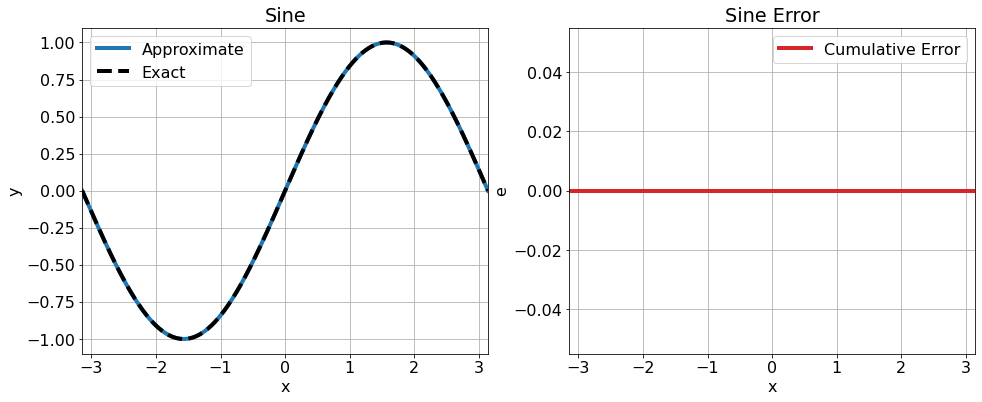

Sine: l2 error = 0.0


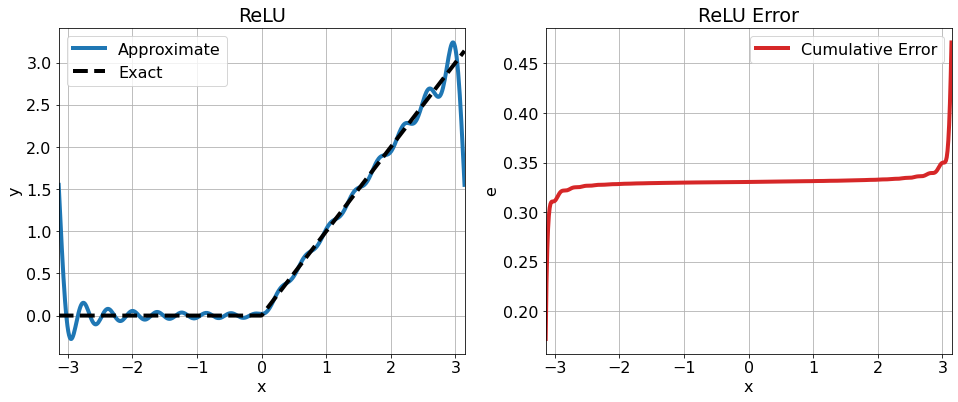

ReLU: l2 error = 0.4712145545851006


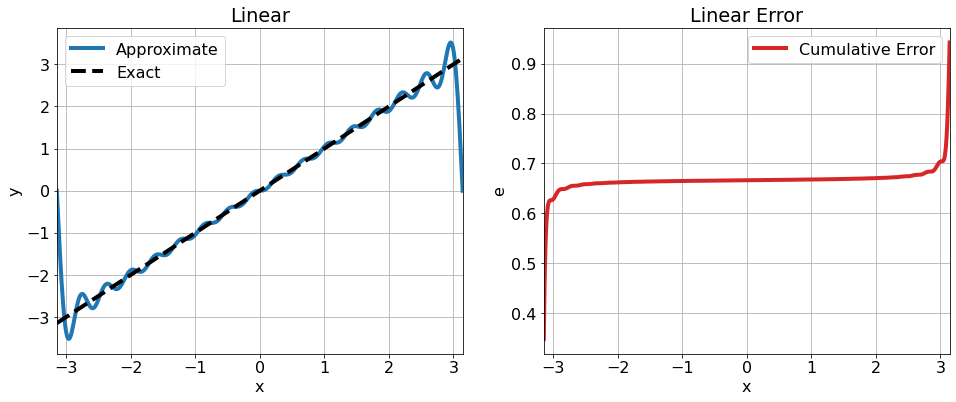

Linear: l2 error = 0.9423091709397505


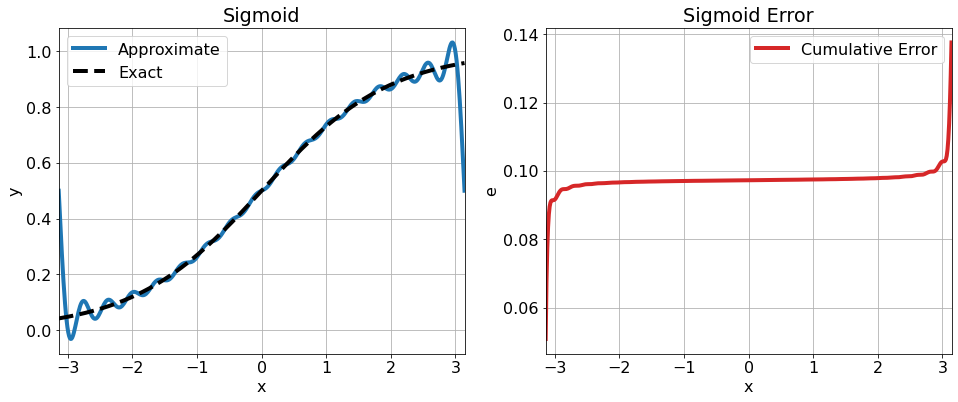

Sigmoid: l2 error = 0.1375595562285733


In [7]:
# Number of points to perform estimations with.
points = 512

# Plot each function's approximation compared to exact equation along with errors.
for name in functions:
    # Create domain, functions, and error.
    x = np.linspace(-np.pi, np.pi, num=points)
    y_approx = functions[name].get_approx(x)
    y_exact = functions[name].get_exact(x)
    y_error = np.sqrt(np.cumsum(functions[name].get_error_l2(x)))
    
    # Create figure.
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    
    # Plot error and approximate and exact functions.
    axes[0].plot(x, y_approx, '-', c='tab:blue', lw=4, label="Approximate")
    axes[0].plot(x, y_exact, '--', c='k', lw=4, label="Exact")
    axes[1].plot(x, y_error, '-', c='tab:red', lw=4, label="Cumulative Error")
    
    # Set axes.
    for i in (0, 1):
        axes[i].set_xlim(-np.pi, np.pi)
        axes[i].set_xlabel('x')
        if i == 1:
            axes[i].set_ylabel('e')
            axes[i].set_title(f"{name} Error")
        else:
            axes[i].set_ylabel('y')
            axes[i].set_title(name)
        axes[i].grid(True)
        axes[i].legend()
    
    # Show the plot.
    plt.show()
    
    # Print the error.
    print(f"{name}: l2 error = {y_error[-1]}")

Depth: 1


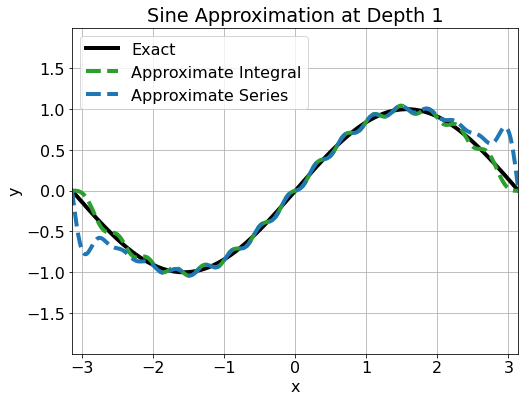

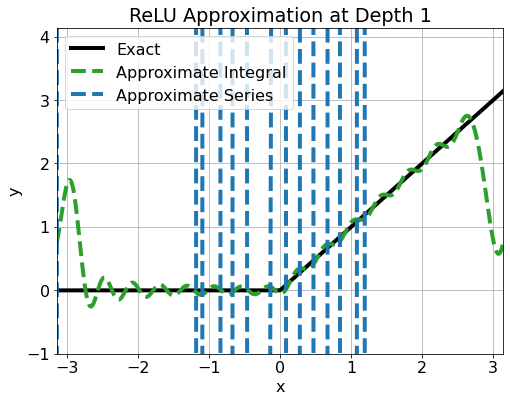

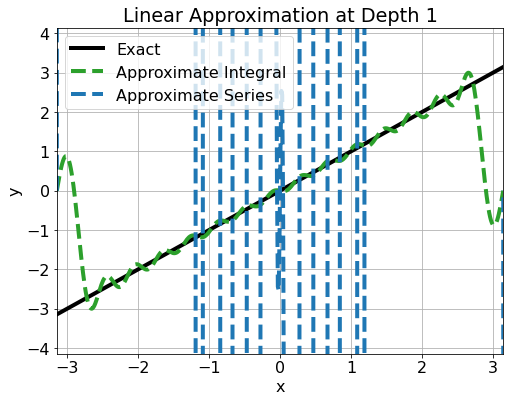

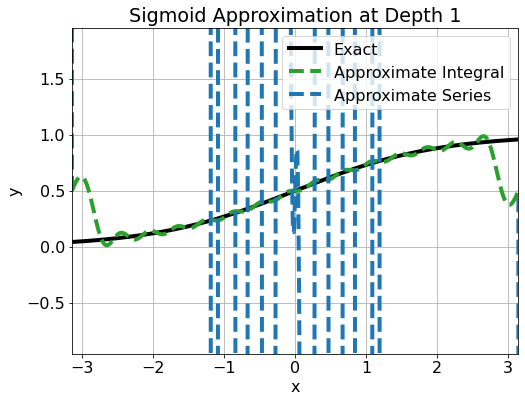

Depth: 3


In [ ]:
# List of number of iterations of the function.
depths = [1, 3, 5, 7]

# The number of terms to form the approximation with.
approx_terms = 16

# Number of points to perform estimations with.
points = 512

# Plot approximations at different depths for each function.
for i, depth in enumerate(depths):
    for name in functions:    
        # Create figure.
        fig, axes = plt.subplots(figsize=(8,6))
        
        # The domain of the function.
        x = np.linspace(-np.pi, np.pi, num=points)
        
        # The exact equation reflects what the neural network generates.
        # Apply the exact function 'depth' times to domain.
        y_exact = x
        for _ in range(depth):
            y_exact = functions[name].get_exact(y_exact)
            
        # The theoretical equation reflects what the neural network would generate
        # if the activation function were replaced with a Fourier approximation at each level.
        # Apply the theoretical function `depth` times to domain.
        y_theory = x
        for _ in range(depth):
            y_theory = functions[name].get_approx(y_theory)
    
        # The Fourier approximate equation is iteratively applying the Fourier transform from one
        # depth to the next.
        # Apply the approximate function `depth` times to domain.
        y_fourier_func = LinearFunction(approx_terms)
        for _ in range(depth):
            y_fourier_func = functions[name].apply_integration(approx_terms, y_fourier_func)
        y_fourier_approx = y_fourier_func(x)
        
        # The algebraic approximate equation reflects the approximate iteration from one depth to the
        # next using our derived equation.
        # Apply the approximate function `depth` times to domain.
        y_algebraic_func = LinearFunction(approx_terms)
        for _ in range(depth):
            y_algebraic_func = functions[name].apply_algebraic(approx_terms, y_algebraic_func)
        y_algebraic_approx = y_algebraic_func(x)

        # Plot exact, theoretical, and approximate functions
        axes.plot(x, y_exact, '-', c='k', lw=4, label="Exact")
#         axes[i].plot(x, y_theory, '--', c='tab:blue', lw=4, label="Theoretical")
        axes.plot(x, y_fourier_approx, '--', c='tab:green', lw=4, label="Approximate Integral")
        axes.plot(x, y_algebraic_approx, '--', c='tab:blue', lw=4, label="Approximate Series")

        # Set axis.
        axes.set_xlim(-np.pi, np.pi)
        axes.set_ylim(np.amin(y_exact) - 1, np.amax(y_exact) + 1)
        axes.set_xlabel('x')
        axes.set_ylabel('y')
        axes.set_title(f"{name} Approximation at Depth {depth}")
        axes.grid(True)
        axes.legend()

        # Show the plot.
        plt.show()